In [163]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import linregress
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

## Data Loading

In [88]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/customer_segmentation_dataset.csv', encoding='latin1')
df.shape

(541909, 8)

In [89]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [90]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

Columns description:
- InvoiceNo: represents each unique transaction (starting with "c" for "Canceled")
- StockCode: assigned to each product
- Description: describe each product
- Quantity: number of units in one transaction
- InvoiceDate: date of transaction
- UniPirce: price for one product
- CustomerID: identifier for each customer
- Country: customer's country

## Initial Data Analysis

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [92]:
df.isnull().sum().sum()

136534

In [93]:
missed_df = df.isnull().sum()
missed_df[missed_df > 0]

Description      1454
CustomerID     135080
dtype: int64

In [94]:
df.duplicated(keep=False).sum()

10147

In [95]:
numerical_columns = df.select_dtypes(include=['int', 'float']).columns.tolist()
object_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns, object_columns

(['Quantity', 'UnitPrice', 'CustomerID'],
 ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country'])

In [96]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


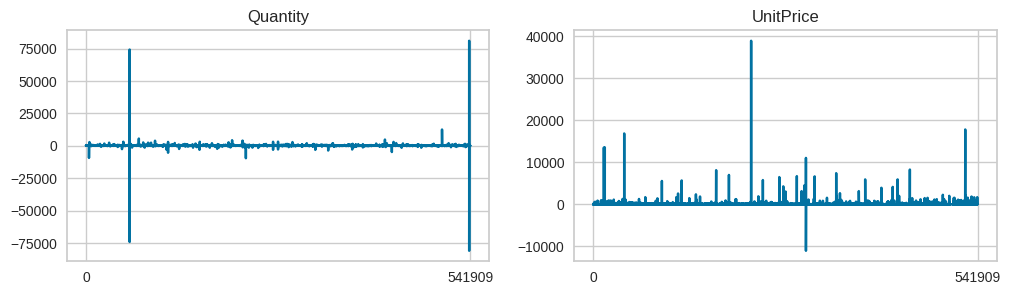

In [97]:
def plot_numerical_dist(data):
  columns = [x for x in numerical_columns if x != 'CustomerID']
  fig, axes = plt.subplots(1, len(columns), figsize=(12, 3))

  for i, column in enumerate(columns):
      data[column].plot(ax=axes[i])
      axes[i].set_title(column)
      axes[i].set_xticks([0, data.shape[0]])

  plt.show()

plot_numerical_dist(df)

In [98]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Summary:
- Dataset has 541909 samples (10147 duplicated) and 8 features
- Description and CustomerID have missed values (1454 and 135080)
- Quantity: min -80995 (negative value should tell about cancelling) and max 80995 (indicates for outliers in data because 75% value is 10)
- UnitPrice: min -11062.06 (should be errors or noise) and max 38970 (means for outlier depends on 75% which is 4.13)
- CustomerID: values from 12346 to 18287
- InvoiceNo: 25900 unique numbers
- StockCode: 40770 unique codes
- Description: 4223 unique product info
- InvoiceDate: 23260 unique dates, in 10/31/2011 14:41 were created 1114 transactions
- Country: 38 unique countries (91.43% is United Kingdom)

## Exploratory Data Analysis

Dealing with missing data

In [99]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100
missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

In [100]:
df = df.dropna(subset=['CustomerID', 'Description'])
df.shape

(406829, 8)

In [101]:
df.isnull().sum().sum()

0

Handling duplicates

In [102]:
df_duplicated = df[df.duplicated(keep=False)].sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
df_duplicated.shape

(10062, 8)

In [103]:
df_duplicated.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


In [104]:
df.drop_duplicates(inplace=True)
df.shape

(401604, 8)

Treating cancelled orders

In [105]:
df['TxStatus'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TxStatus
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


In [106]:
df['TxStatus'].value_counts()

Completed    392732
Cancelled      8872
Name: TxStatus, dtype: int64

In [107]:
cancelled_transactions = df[df['TxStatus'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1).T

,count,mean,std,min,25%,50%,75%,max
Quantity,8872.0,-30.774910,1172.249902,-80995.00,-6.00,-2.00,-1.00,-1.0
UnitPrice,8872.0,18.899512,445.190864,0.01,1.45,2.95,4.95,38970.0


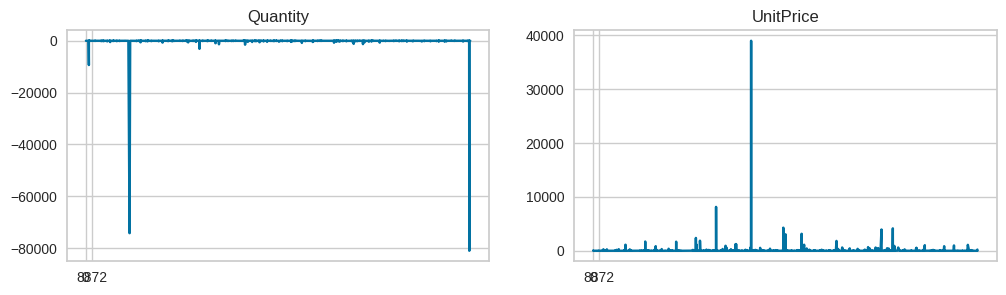

In [108]:
plot_numerical_dist(cancelled_transactions)

Count of cancelled transactions

In [109]:
cancelled_transactions.shape[0] / df.shape[0] * 100

2.209141343213713

Handling anomalies in StockCode

In [110]:
df['StockCode'].nunique()

3684

In [111]:
df['StockCode'].value_counts().head(10)

85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
20725     1346
22720     1224
POST      1196
22197     1110
23203     1108
Name: StockCode, dtype: int64

In [112]:
unique_codes = df['StockCode'].unique()
chars_in_codes = pd.Series(unique_codes).apply(lambda x: sum(c.isdigit() for c in str(x)))
chars_in_codes.value_counts()

5    3676
0       7
1       1
dtype: int64

Seems StockCode has values which isn't a actual code

In [113]:
uncommon_codes = df['StockCode'][df['StockCode'].apply(lambda x: sum(c.isdigit() for c in str(x)) != 5)]
uncommon_codes.head()

45      POST
141        D
386     POST
1123    POST
1423      C2
Name: StockCode, dtype: object

Count of uncommon codes

In [114]:
uncommon_codes.count() / df['StockCode'].count() * 100

0.4768378801007958

Removing uncommon codes

In [115]:
df = df[~df['StockCode'].isin(uncommon_codes.tolist())]
df.shape

(399689, 9)

Cleaning Description

In [116]:
df['Description'].value_counts().head(10)

WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
LUNCH BAG RED RETROSPOT               1345
SET OF 3 CAKE TINS PANTRY DESIGN      1224
LUNCH BAG  BLACK SKULL.               1099
PACK OF 72 RETROSPOT CAKE CASES       1062
SPOTTY BUNTING                        1026
Name: Description, dtype: int64

In [117]:
uncommon_desc = [desc for desc in df['Description'].unique() if any(char.islower() for char in desc)]
uncommon_desc

['BAG 500g SWIRLY MARBLES',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 40x40cm',
 'FRENCH BLUE METAL DOOR SIGN No',
 'BAG 250g SWIRLY MARBLES',
 'BAG 125g SWIRLY MARBLES',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 'NUMBER TILE COTTAGE GARDEN No',
 'FOLK ART GREETING CARD,pack/12',
 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
 'POLYESTER FILLER PAD 65CMx65CM',
 'NUMBER TILE VINTAGE FONT No ',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 60x40cm',
 'FLOWERS HANDBAG blue and orange',
 'Next Day Carriage',
 'THE KING GIFT BAG 25x24x12cm',
 'High Resolution Image']

Through all uncommon descriptions there are two which aren't product desc (Next Day Carriage and High Resolution Image)

In [118]:
services = ["Next Day Carriage", "High Resolution Image"]

Count of uncommon desc

In [119]:
uncommon_desc =  df['Description'][df['Description'].isin(services)]
uncommon_desc.shape[0] / df['Description'].count() * 100

0.02076614567826485

Removing uncommon desc

In [120]:
df = df[~df['Description'].isin(uncommon_desc)]
df.shape

(399606, 9)

## Feature Engineering

*Creating dataset with each unique customer as sample*

Finding days since last purchase by customer

In [121]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date

customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
most_recent_date = df['InvoiceDay'].max()

customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

customer_data['DaysSinceLastPurchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

customer_data.drop(columns=['InvoiceDay'], inplace=True)
customer_data.head()

,CustomerID,DaysSinceLastPurchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Getting total transactions count and total quantity

In [122]:
total_tx = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_quantity = df.groupby('CustomerID')['Quantity'].sum().reset_index()

total_tx.rename(columns={'InvoiceNo': 'TotalTx'}, inplace=True)
total_quantity.rename(columns={'Quantity': 'TotalQuantity'}, inplace=True)

customer_data = pd.merge(customer_data, total_tx, on='CustomerID')
customer_data = pd.merge(customer_data, total_quantity, on='CustomerID')
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


Calculating total and average spend by customer

In [123]:
df['TotalSpend'] = df['UnitPrice'] * df['Quantity']

total_spend = df.groupby('CustomerID')['TotalSpend'].sum().reset_index()
average_spend = total_spend.merge(total_tx, on='CustomerID')

average_spend['AverageSpend'] = average_spend['TotalSpend'] / average_spend['TotalTx']
average_spend.drop(['TotalTx'], axis=1, inplace=True)

customer_data = pd.merge(customer_data, average_spend, on='CustomerID')
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


Finding count of unique products

In [124]:
unique_products = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products.rename(columns={'StockCode': 'UniqueProducts'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products, on='CustomerID')
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


Getting average count of days between purchases and favorite shopping day/hour

In [125]:
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'AverageDaysBetweenPurchases'}, inplace=True)

favorite_shopping_day = df.groupby(['CustomerID', 'DayOfWeek']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'DayOfWeek']]

favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts,AverageDaysBetweenPurchases,DayOfWeek,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


Defining customer country and creating IsUK column because UK has huge amount of data but other countries are also important

In [126]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='NumberOfTx')

customer_main_country = customer_country.sort_values('NumberOfTx', ascending=False).drop_duplicates('CustomerID')
customer_main_country['IsUK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'IsUK']], on='CustomerID', how='left')
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts,AverageDaysBetweenPurchases,DayOfWeek,Hour,IsUK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


Cancellation Insights

In [127]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

cancelled_transactions = df[df['TxStatus'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'CancellationFrequency'}, inplace=True)

customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')
customer_data['CancellationFrequency'].fillna(0, inplace=True)
customer_data['CancellationRate'] = customer_data['CancellationFrequency'] / total_transactions['InvoiceNo']
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts,AverageDaysBetweenPurchases,DayOfWeek,Hour,IsUK,CancellationFrequency,CancellationRate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


Dealing with seasonality and trends

In [128]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['TotalSpend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['TotalSpend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'MonthlySpendingMean', 'std': 'MonthlySpendingStd'}, inplace=True)
seasonal_buying_patterns['MonthlySpendingStd'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    length = len(spend_data)
    return linregress(np.arange(length), spend_data)[0] if length > 1 else 0

spending_trends = monthly_spending.groupby('CustomerID')['TotalSpend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'TotalSpend': 'SpendingTrend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts,AverageDaysBetweenPurchases,DayOfWeek,Hour,IsUK,CancellationFrequency,CancellationRate,MonthlySpendingMean,MonthlySpendingStd,SpendingTrend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


## EDA customer data

Converting CustomerID to object

In [129]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

In [130]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   4282 non-null   object 
 1   DaysSinceLastPurchase        4282 non-null   int64  
 2   TotalTx                      4282 non-null   int64  
 3   TotalQuantity                4282 non-null   int64  
 4   TotalSpend                   4282 non-null   float64
 5   AverageSpend                 4282 non-null   float64
 6   UniqueProducts               4282 non-null   int64  
 7   AverageDaysBetweenPurchases  4282 non-null   float64
 8   DayOfWeek                    4282 non-null   int64  
 9   Hour                         4282 non-null   int64  
 10  IsUK                         4282 non-null   int64  
 11  CancellationFrequency        4282 non-null   float64
 12  CancellationRate             4282 non-null   float64
 13  MonthlySpendingMea

Dealing with outlier using Isolation Forest

In [131]:
model = IsolationForest(contamination=0.05, random_state=0)

customer_data['OutlierScores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())
customer_data['IsOutlier'] = [1 if x == -1 else 0 for x in customer_data['OutlierScores']]
customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts,AverageDaysBetweenPurchases,DayOfWeek,Hour,IsUK,CancellationFrequency,CancellationRate,MonthlySpendingMean,MonthlySpendingStd,SpendingTrend,OutlierScores,IsOutlier
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000,1,0
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000,1,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000,1,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000,1,0


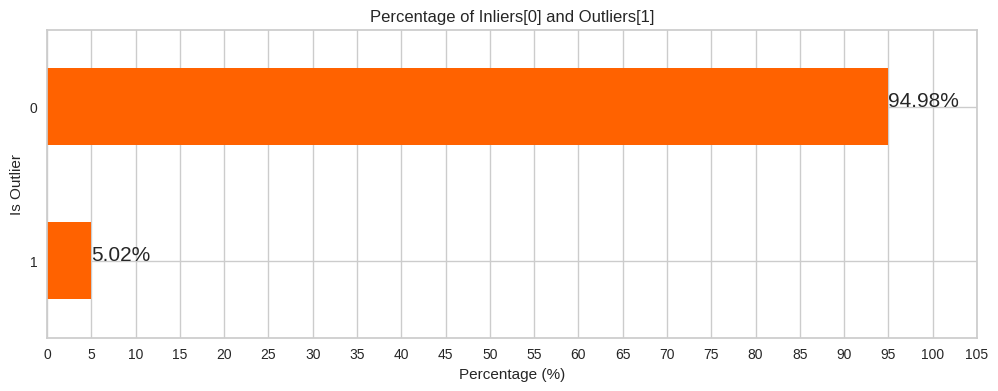

In [132]:
plt.figure(figsize=(12, 4))

outlier_percentage = customer_data['IsOutlier'].value_counts(normalize=True) * 100
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers[0] and Outliers[1]')
plt.xticks(ticks=np.arange(0, 110, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

Dropping outliers

In [133]:
customer_data_cleaned = customer_data[customer_data['IsOutlier'] == 0]
customer_data_cleaned = customer_data_cleaned.drop(columns=['OutlierScores', 'IsOutlier'])
customer_data_cleaned.reset_index(drop=True, inplace=True)
customer_data_cleaned.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts,AverageDaysBetweenPurchases,DayOfWeek,Hour,IsUK,CancellationFrequency,CancellationRate,MonthlySpendingMean,MonthlySpendingStd,SpendingTrend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


Look at correlation between numeric columns

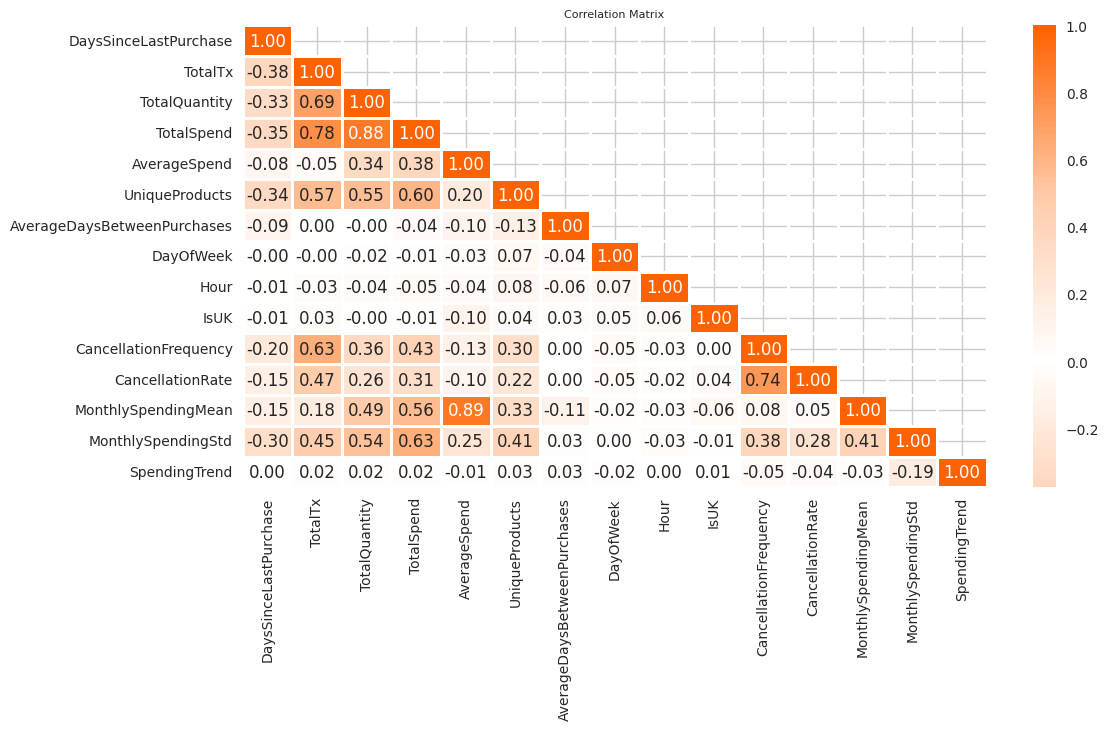

In [141]:
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=1)
plt.title('Correlation Matrix', fontsize=8)
plt.show()

High correlated columns based on plot:
- MonthlySpendingMean and AverageTransactionValue
- TotalSpend and TotalProductsPurchased
- TotalTx and TotalSpend
- TotalTx and TotalProductsPurchased
- CancellationRate and CancellationFrequency

## Preprocessing

Scaling numerical values

In [142]:
customer_data_scaled = customer_data_cleaned.copy()

categorical_columns = ['CustomerID', 'Is_UK', 'Day_Of_Week']
numerical_columns = customer_data_cleaned.columns.difference(categorical_columns)

scaler = StandardScaler()
customer_data_scaled[numerical_columns] = scaler.fit_transform(customer_data_scaled[numerical_columns])
customer_data_scaled.head()

,CustomerID,DaysSinceLastPurchase,TotalTx,TotalQuantity,TotalSpend,AverageSpend,UniqueProducts,AverageDaysBetweenPurchases,DayOfWeek,Hour,IsUK,CancellationFrequency,CancellationRate,MonthlySpendingMean,MonthlySpendingStd,SpendingTrend
0,12346.0,2.345715,-0.481865,-0.754881,-0.825690,-1.315527,-0.901583,-0.310981,-0.835322,-1.088679,0.307817,0.404778,0.407980,-1.332408,-0.716186,0.091296
1,12347.0,-0.904883,0.719401,2.009681,2.416578,1.529443,0.805278,-0.128855,-0.835322,0.643243,-3.248689,-0.535389,-0.428711,0.996343,1.269329,0.117239
2,12348.0,-0.170228,-0.001359,1.867966,0.255497,0.344701,-0.566905,0.672062,0.244200,2.808144,-3.248689,-0.535389,-0.428711,0.026572,0.470659,-0.492138
3,12349.0,-0.743863,-0.722118,-0.046307,0.270776,5.419230,0.286526,-0.310981,-1.375083,-1.521659,-3.248689,-0.535389,-0.428711,4.180329,-0.716186,0.091296
4,12350.0,2.194759,-0.722118,-0.534435,-0.604223,0.044778,-0.650574,-0.310981,-0.295561,1.509203,-3.248689,-0.535389,-0.428711,-0.218930,-0.716186,0.091296


In [143]:
customer_data_scaled.set_index('CustomerID', inplace=True)

Applying PCA for a dimensionality reduction

In [155]:
pca = PCA()
pca.fit(customer_data_scaled)

PCA()

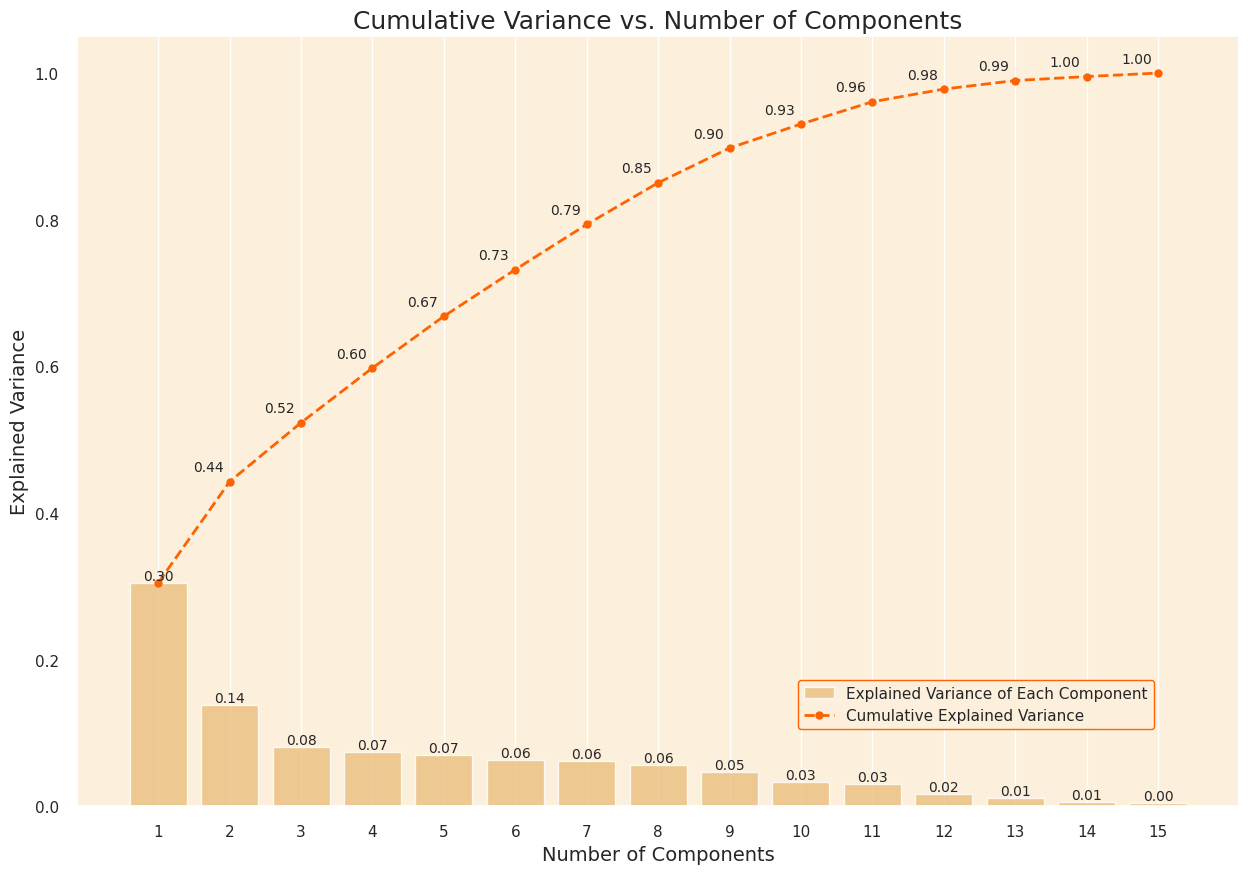

In [158]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(15, 10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')
plt.grid(axis='both')
plt.show()

Optimal number of components is 8

In [159]:
pca = PCA(n_components=8)
customer_data_pca = pca.fit_transform(customer_data_scaled)

customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])
customer_data_pca.index = customer_data_scaled.index
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
CustomerID,,,,,,,,
12346.0,-2.250402,-1.594865,1.283165,-0.736359,-1.064396,-0.741595,-1.005340,-0.225428
12347.0,3.307812,2.269466,0.861618,0.438539,-0.567855,2.214223,2.138737,-0.227123
12348.0,0.635225,1.015742,-0.248487,-0.301100,0.349057,2.279176,3.208490,1.358180
12349.0,1.741303,6.134855,3.250105,-0.223941,-1.379132,0.988118,0.751686,0.873578
12350.0,-1.998085,0.912221,0.713994,-1.343488,-1.476976,1.782999,1.937477,1.201467


## Model Building

Determining a optimal number of clusters for KMeans

Using Elbow Method

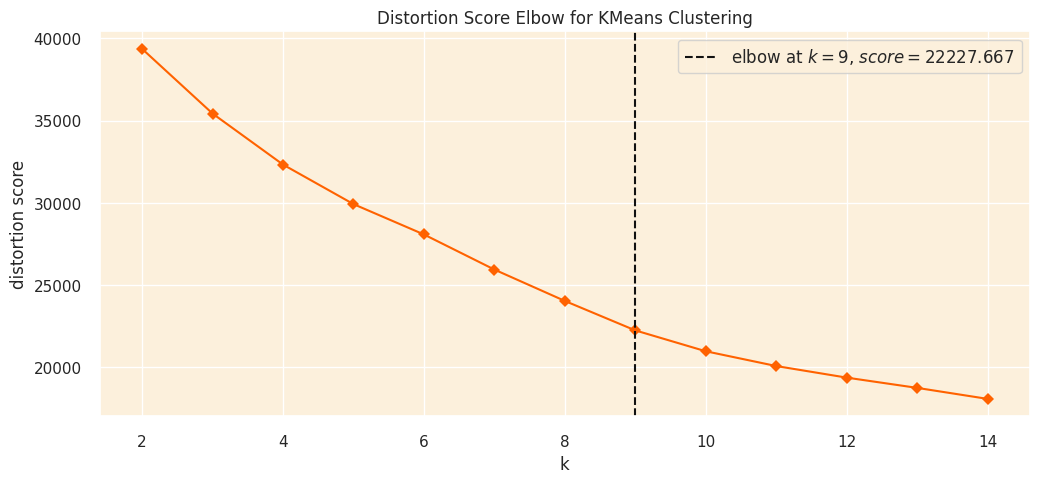

In [162]:
fig, ax = plt.subplots(figsize=(12, 5))

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)
visualizer.fit(customer_data_pca)
visualizer.show();

Using Silhouette Method

In [170]:
def silhouette_analysis(df, start_k, stop_k):
    plt.figure(figsize=(20, 50))
    sns.set_palette(['darkorange'])

    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)
    first_plot = plt.subplot(grid[0, :])

    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    colors = sns.color_palette("bright")
    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

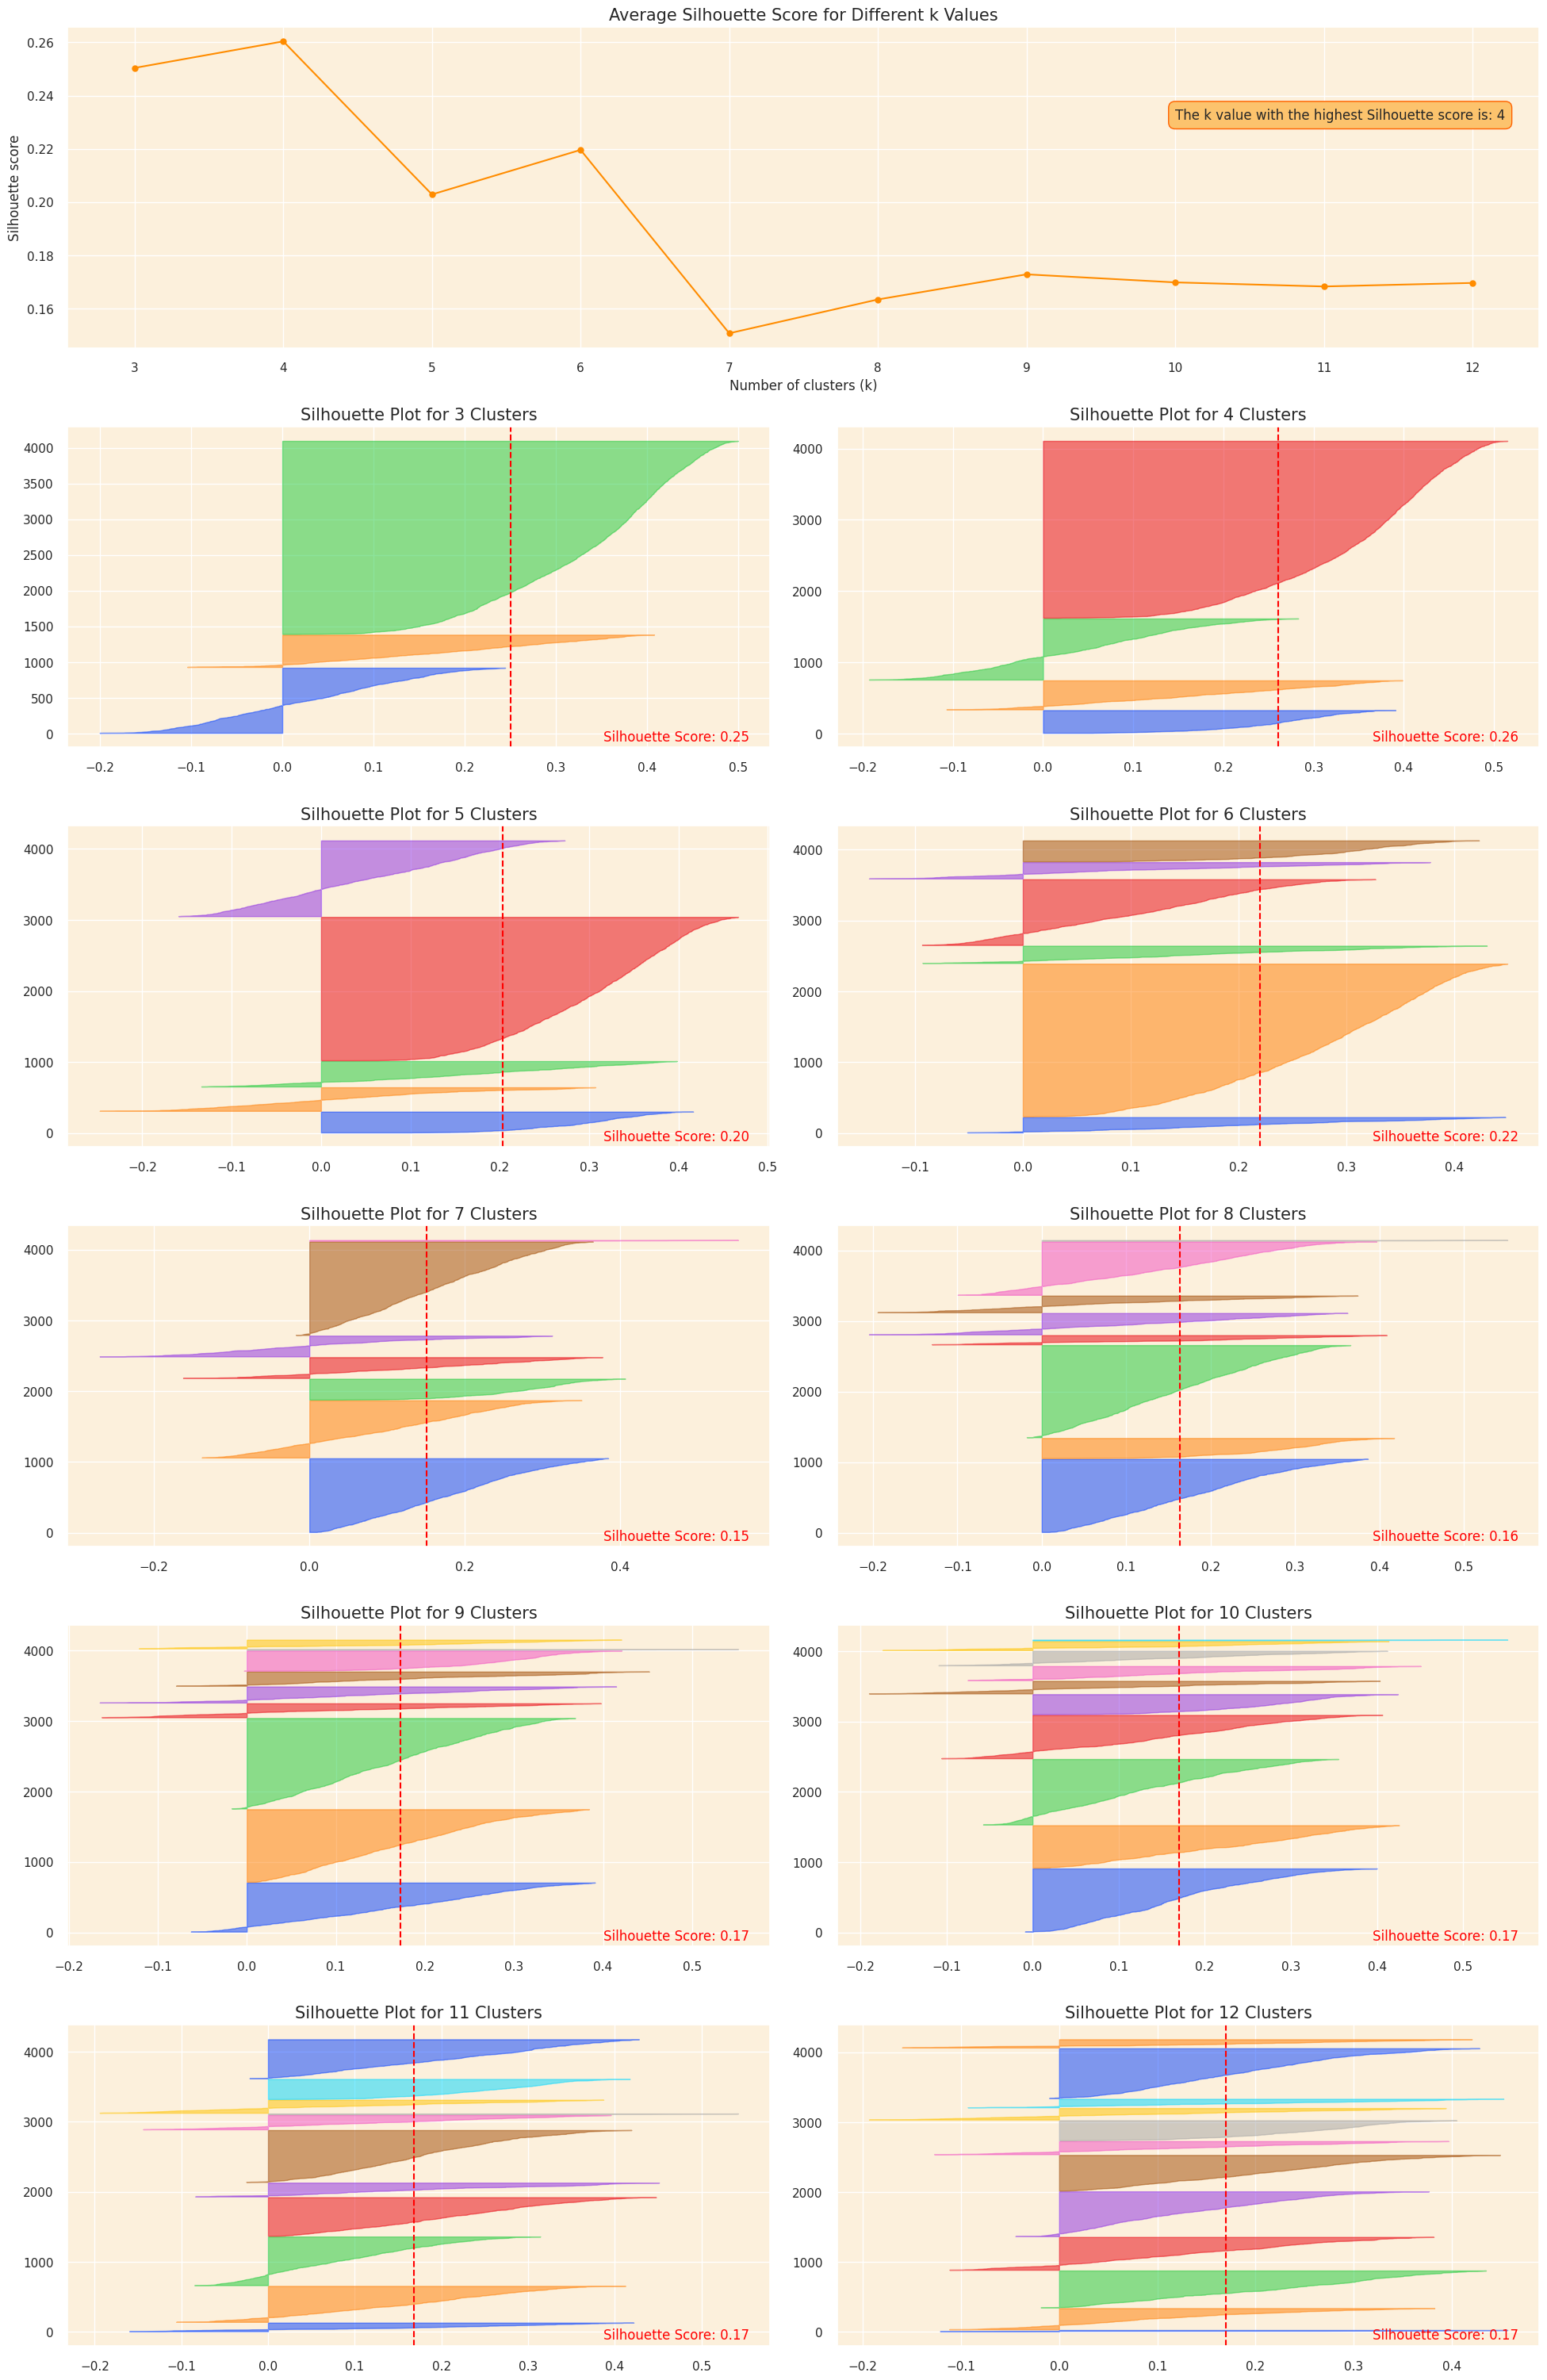

In [171]:
silhouette_analysis(customer_data_pca, 3, 12)

Creating a KMeans model with 4 clusters

In [212]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=0)

In [213]:
cluster_frequencies = Counter(kmeans.labels_)
cluster_frequencies

Counter({1: 1578, 3: 346, 0: 298, 2: 1845})

In [214]:
customer_data_pca['cluster'] = kmeans.labels_
customer_data_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,cluster
CustomerID,,,,,,,,,
12346.0,-2.250402,-1.594865,1.283165,-0.736359,-1.064396,-0.741595,-1.005340,-0.225428,1
12347.0,3.307812,2.269466,0.861618,0.438539,-0.567855,2.214223,2.138737,-0.227123,3
12348.0,0.635225,1.015742,-0.248487,-0.301100,0.349057,2.279176,3.208490,1.358180,3
12349.0,1.741303,6.134855,3.250105,-0.223941,-1.379132,0.988118,0.751686,0.873578,3
12350.0,-1.998085,0.912221,0.713994,-1.343488,-1.476976,1.782999,1.937477,1.201467,1
...,...,...,...,...,...,...,...,...,...
18280.0,-2.219182,-0.025197,1.531528,-0.097417,-0.874645,-0.869919,-0.916226,-0.898638,1
18281.0,-2.268259,-0.541672,-0.543883,-0.260854,0.205313,0.879438,-2.002734,0.137663,2
18282.0,-1.181878,-1.641216,-0.411375,0.312123,0.644562,0.321618,-0.052723,0.434785,2


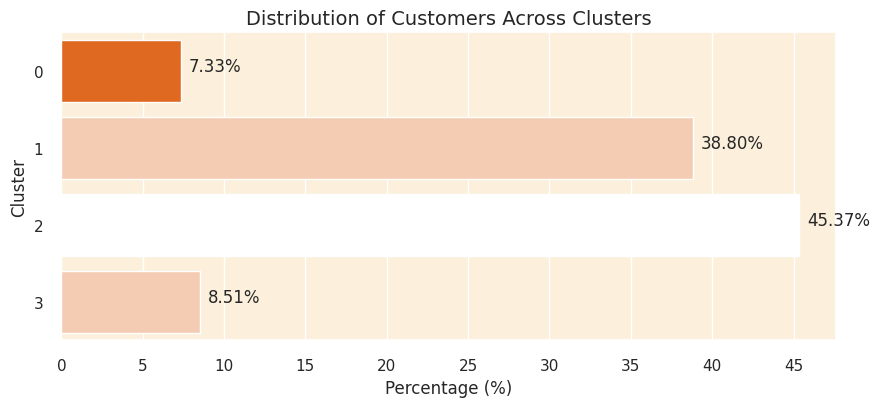

In [215]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')
plt.show()

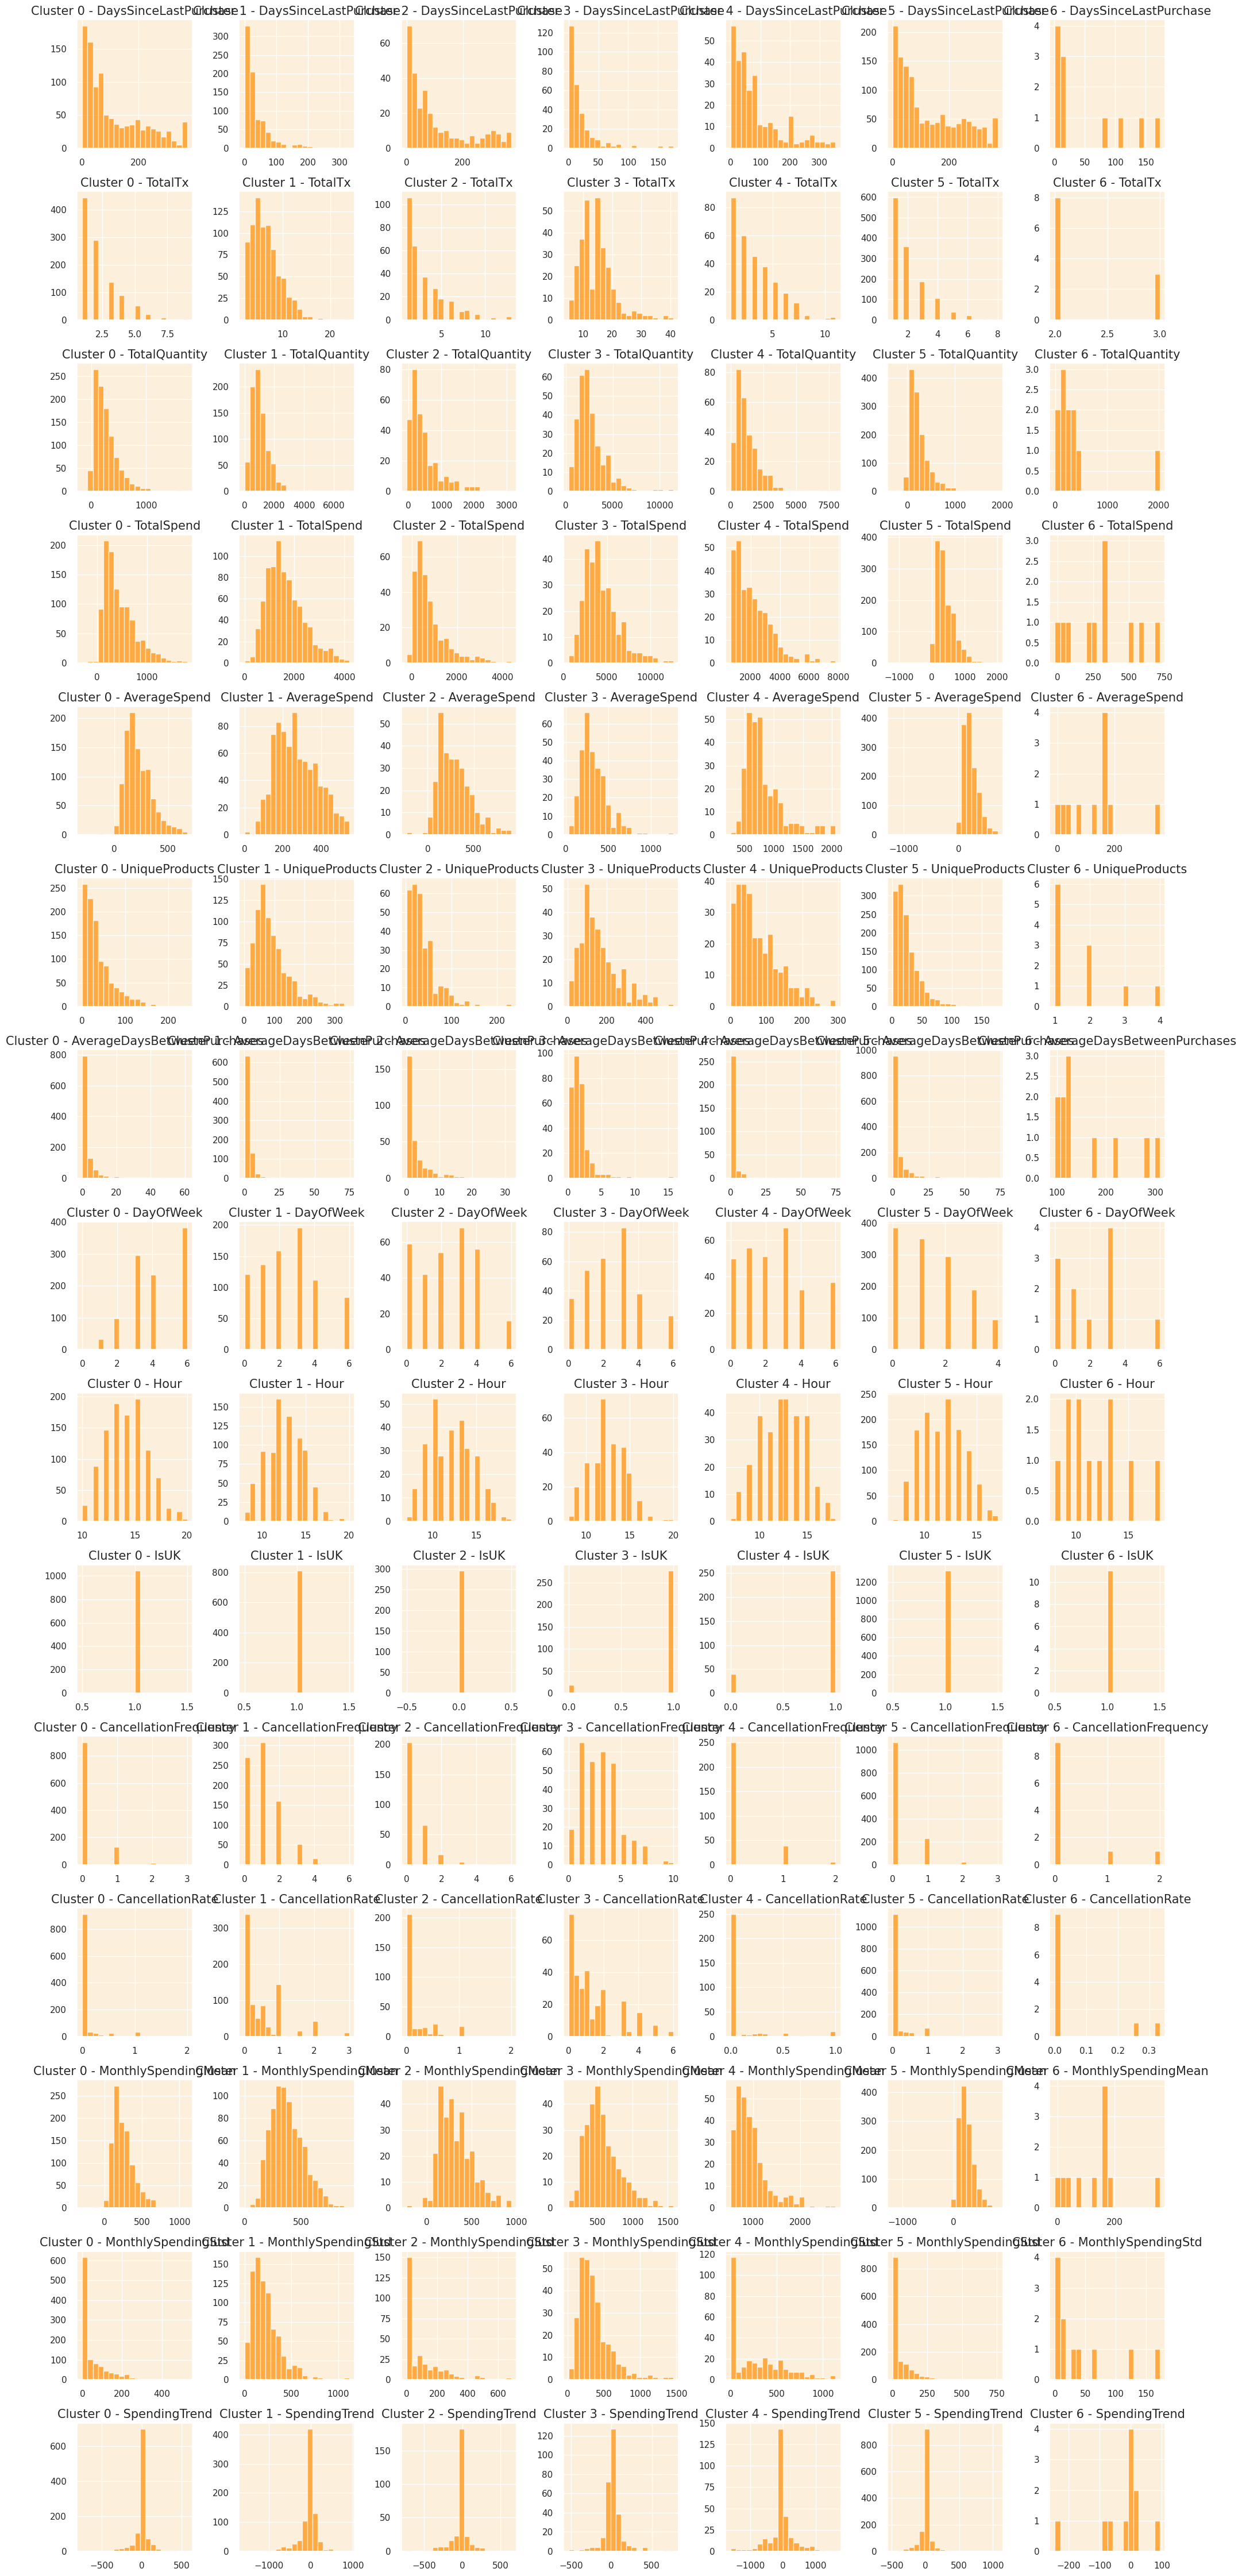

In [216]:
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

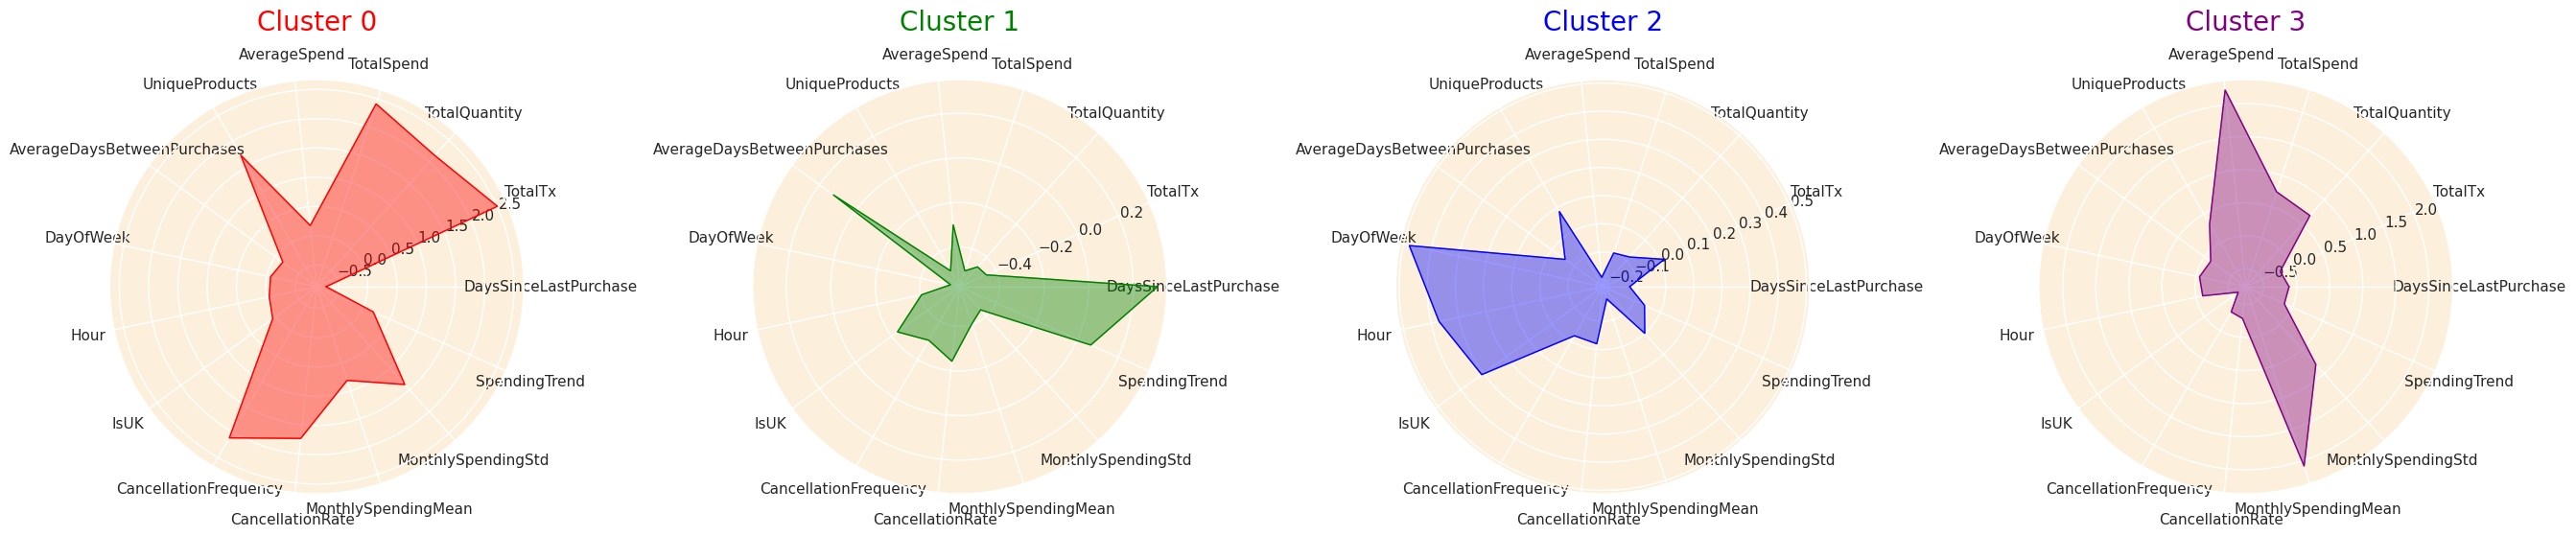

In [233]:
customer_data_cleaned['cluster'] = kmeans.labels_
df_customer = customer_data_cleaned.set_index('CustomerID')

scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

cluster_centroids = df_customer_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=1, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(27, 15), subplot_kw=dict(polar=True), nrows=1, ncols=4)

colors = ['red', 'green', 'blue', 'purple']
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]
    create_radar_chart(ax[i], angles, data, color, i)

    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])

plt.tight_layout()
plt.show()